In [68]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-malignant-vs-benign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174469%2F505351%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T191634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D316d3f4cf652c94fa38389821d64765f36c3caee20b9a51d038064d61f5b47fcd825062a82bad195714f1b5497e7069e6ec9555843a1222e6d4125d8b1b1930aae7063684c7c9c25d4f0939a7874222a64dfc8b09ba79807805e7fd80dfb4e6d12f0548b6f4e83fd49aeeb3b9324abd85848cc56571afc2db9bdf08a4982c9e4c7defcd0218918d774628b80d280476beb6d7125f6e242b4b4f154d5beabc45bb8c6ac5d02d0b7cb36c6f55f9ccc501277ce4e52698c4b6466f6d4d06c81cc2a2c8498edb45063e98e6e2f7159fa7478c2ff0b63d5e8294848647751b407a4cb82cd05753225d1cb8a9a739f6f74adc21c9a52eee5cf3651783aab14d24f65e7,prediction-file:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4906083%2F8264828%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T191634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a5a2d4ad15a88faf413ecb0f5ece9e9f5904fcb7b4324c4b8903dee73bc22ad9dd4a13b1f3731bfa8b305768cdf9f932b9447349e0b1d4851839f22fd9bdf05de8a7178e1a82def43016473eb145651cdee888ffb421e3054e0ca349376d9f91d314f3311d97a299f2509965c0e324f7f444e0b01375249fb8d43659a59b1ecec9ef6e37174121581a3e53efb75d9b50632e243a7b8e10aed797623013dc475f66fb1ee997b5e4037630644cc20eddb1bf6032a9c35909100e063a4149117b9a96d35f15724e5e264de480e1037b4059a99cd36b33781bb346ef52f8202a0a2638d641f6d8673702ed111b6749af6043e9fb0f6daea0610f92d382067cd5a42'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 340467838 bytes downloaded
Downloaded and uncompressed: skin-cancer-malignant-vs-benign
[==================================================] 1119263 bytes downloaded
Downloaded and uncompressed: prediction-file
Data source import complete.


In [69]:
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        pass


# **import libraries**

In [70]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import random
import cv2
warnings.filterwarnings("ignore")
print(tf.__version__)

2.15.0


# path

In [71]:
training ="/kaggle/input/skin-cancer-malignant-vs-benign/train"
testing="/kaggle/input/skin-cancer-malignant-vs-benign/test"
val_path="/kaggle/input/prediction-file"

# load data and vis

In [72]:
#skin_cancer_data = train dataset  not all data
Skin_cancer_data='/kaggle/input/skin-cancer-malignant-vs-benign/train'
labels_list=os.listdir(Skin_cancer_data)#This line tries to read all the subdirectories present
labels_list #This code snippet only retrieves folder names, it doesn't access the actual image data.

['malignant', 'benign']

In [73]:
images=[]
labels=[]

for i in labels_list:
    path=os.path.join(Skin_cancer_data,i)
#Extracting image filenames:
    for img in os.listdir(path):
        image_path=os.path.join(path,img)
        images.append(image_path)
        labels.append(i)
print(images[0])
print(labels[0])

/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant/453.jpg
malignant


In [74]:
print("Total images:", len(images))
print("Total labels:", len(labels))

Total images: 2637
Total labels: 2637


In [75]:
# convert fills to  table dataset
#  'images' and 'labels' are your lists of images and labels
df = pd.DataFrame({"images": images, "labels": labels})

# Creating a binary label column based on whether the label is "malignant" or not
df['label_binary'] = np.where(df["labels"].values == "malignant", 1, 0)

# Displaying the first few rows of the DataFrame
df.head()



,images,labels,label_binary
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,1


In [76]:
df.tail()

,images,labels,label_binary
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0
2636,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,0


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('images').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label_binary']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label_binary'}, axis=1)
              .sort_values('label_binary', ascending=True))
  xs = counted['label_binary']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('label_binary', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('images')):
  _plot_series(series, series_name, i)
  fig.legend(title='images', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label_binary')
_ = plt.ylabel('count()')

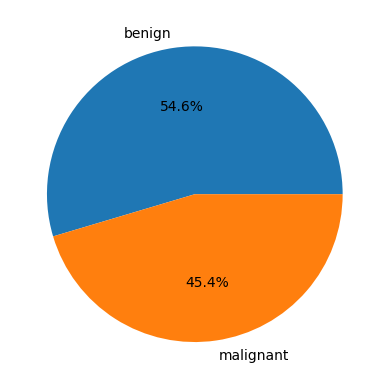

In [77]:
x = df['labels'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.1f%%')
plt.show()


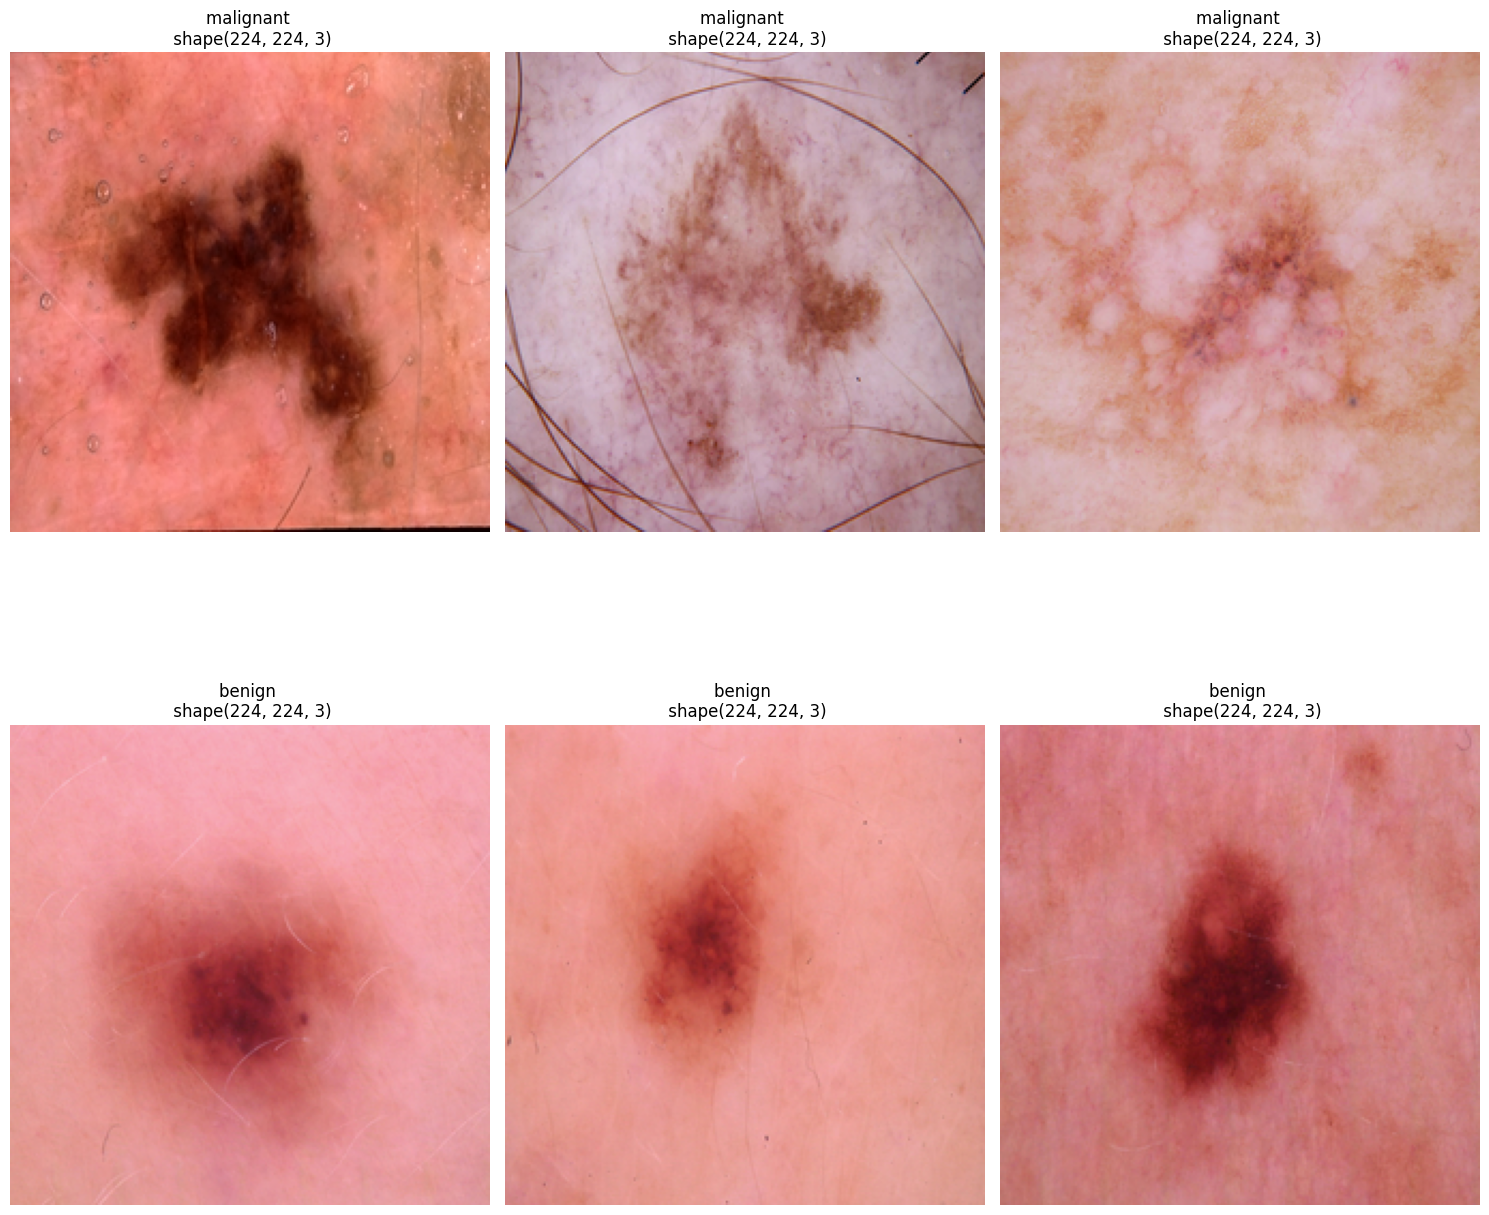

In [78]:
# display random images
fig,ax=plt.subplots(2,3,figsize=(15,15))
p=0
for label in labels_list:

    img=df["images"][df["labels"]==label]
    select_images= random.choices(img.values,k=3)

    for i,img in enumerate(select_images):
        im=cv2.imread(img)
        im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(im_rgb)
        ax[p,i].set_title(f"{label} \n shape{im_rgb.shape}")
        ax[p,i].axis("off")

    p+=1
fig.tight_layout()
fig.show()

# **Image Preprocessing And Augmentation **

In [79]:
#data preprocessing and augmentation during training
#shear_range=0.2, This randomly applies a shearing transformation to the image.
#zoom_range=0.2, This randomly applies a zooming to the image.
#horizontal_flip=True, This randomly applies  a horizontal and vertical flip
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, vertical_flip=True)

test_data_gen = ImageDataGenerator(rescale=1./255)


In [80]:
# Load and preprocess training data
training_set = train_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/train',
                                                 target_size=(64,64),#resizes all images to a uniform size of 64x64 pixels.
                                                 batch_size=32,  #the number of images processed by the model at each training step
                                                 class_mode='binary')

# Load and preprocess test data
test_set = test_data_gen.flow_from_directory('/kaggle/input/skin-cancer-malignant-vs-benign/test',
                                            target_size=(64,64),
                                            batch_size=32,
                                            class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [81]:
# the output  image shape  = (height,width,RGB)
training_set.image_shape

(64, 64, 3)

# Building CNN layers + NN

In [100]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(base_model)

# Add custom layers on top
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               262272    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14985281 (57.16 MB)
Trainable params: 270593 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

In [93]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 6, 6, 128)        

# **Train the model**


In [101]:
#step_per_epoch= 1440(number of data-train)/ 32 (batch-size)
history = model.fit(training_set,
                    steps_per_epoch=45,
                    epochs=25,
                    validation_data=test_set)

Epoch 1/25
45/45 [==============================] - 9s 145ms/step - loss: 0.5282 - accuracy: 0.7305 - val_loss: 0.4697 - val_accuracy: 0.7955
Epoch 2/25
45/45 [==============================] - 5s 105ms/step - loss: 0.4305 - accuracy: 0.7980 - val_loss: 0.4140 - val_accuracy: 0.8076
Epoch 3/25
45/45 [==============================] - 6s 142ms/step - loss: 0.4202 - accuracy: 0.7980 - val_loss: 0.3879 - val_accuracy: 0.7939
Epoch 4/25
45/45 [==============================] - 5s 106ms/step - loss: 0.3529 - accuracy: 0.8374 - val_loss: 0.3647 - val_accuracy: 0.8197
Epoch 5/25
45/45 [==============================] - 6s 123ms/step - loss: 0.3889 - accuracy: 0.8132 - val_loss: 0.3719 - val_accuracy: 0.8212
Epoch 6/25
45/45 [==============================] - 5s 106ms/step - loss: 0.3542 - accuracy: 0.8445 - val_loss: 0.4069 - val_accuracy: 0.8121
Epoch 7/25
45/45 [==============================] - 6s 125ms/step - loss: 0.3957 - accuracy: 0.8051 - val_loss: 0.3920 - val_accuracy: 0.8182
Epoch 

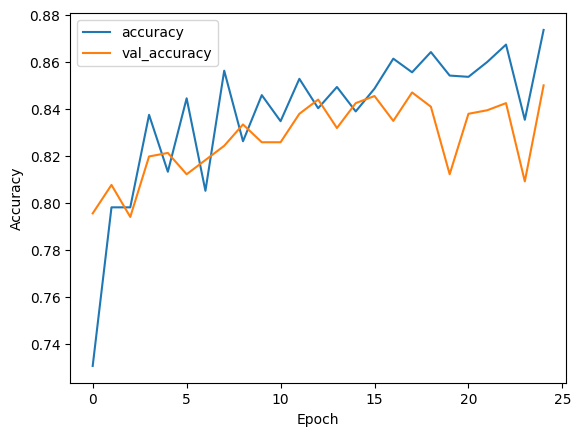

In [102]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Plot training history**

In [103]:
test_loss, test_acc = model.evaluate(test_set, steps=5)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


5/5 [==============================] - 0s 69ms/step - loss: 0.3724 - accuracy: 0.8375
Test accuracy: 0.8374999761581421
Test loss: 0.37239140272140503


# Testing

In [104]:
from keras.preprocessing import image
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/m/54.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 [==============================] - 1s 682ms/step
The prediction result is: malignant


In [105]:
# Load image
predict_image_path = "/kaggle/input/prediction-file/pre/b/18.jpg"
predict_image = image.load_img(predict_image_path, target_size=(64, 64))
predict_image = image.img_to_array(predict_image)
predict_image = np.expand_dims(predict_image, axis=0)#adds an extra dimension to the image array.

# Predict
result = model.predict(predict_image)

# Define class indices
class_indices = {'benign': 0, 'malignant': 1}

# Interpret prediction
if result[0][0] == 0:
    prediction = "benign"
else:
    prediction = "malignant"

# Print prediction result
print("The prediction result is:", prediction)


1/1 [==============================] - 0s 20ms/step
The prediction result is: benign


# Evaluation

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score

# Evaluate model performance
y_true = test_set.classes
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print(classification_report(y_true, y_pred))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

# Print F1-score
print("F1-score:", f1_score(y_true, y_pred))

# Print precision
print("Precision:", precision_score(y_true, y_pred))

# Print accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))


21/21 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       360
           1       0.43      0.49      0.46       300

    accuracy                           0.47       660
   macro avg       0.48      0.48      0.47       660
weighted avg       0.48      0.47      0.48       660

[[167 193]
 [154 146]]
F1-score: 0.45696400625978095
Precision: 0.4306784660766962
Accuracy: 0.47424242424242424
